# Iskanje besed specifičnih za dokumente z uporabo vložitev fastText

Kot je že prikazano v enem od prejšnjih primerov, je z uporabo vložitev fastText zelo enostavno računati razdalje in podobnosti med dokumenti in besedami. Takrat smo pokazali, kako za eden dokument lahko določimo specifične besede z iskanjem tistih, ki so najbolj podobne dokumentu. Vendar pa je lahko beseda zelo podobna tudi ostalim dokumentom in takrat bi rekli, da taka beseda ne bo specifična za kateri koli dokument. V takem primeru lahko pri računanju specifične besede za določeni dokument upoštevamo tudi njeno podobnost z drugimi dokumenti. Tako želimo dobiti tiste besede, ki so čim bližje ciljnemu dokumentu in čim bolj daleč stran od vseh ostalih.

Iz seznama predlogov vladi si izberimo zadnjih 100 dokumentov, jih predobledajmo na isti način kot v prejšnjih primerih in za vsak dokument izračunajmo najbolj specifične besede. Uporabili bomo dva pristopa z eno ključno razliko - pri prvem pristopu je kandidat za specifično besedo posameznega dokumenta vsaka beseda, ki se nahaja v korpusu, pri drugem so pa kandidati le besede, ki se nahajajo v ciljenm dokumentu. Pričakujemo, da bodo pri prvem pristopu boljši rezultati, vendar je tudi časovna zahtevnost računanja večja.

In [1]:
from textsemantics.server_api import ServerAPI
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from flair.data import Sentence
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nltk.download('stopwords', quiet=True)

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
datasets = api.list_datasets()
metadata = api.get_metadata(datasets[2][0], sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
texts = [text for text in texts if len(text) > 50]

tokens_list = preprocess(texts)

In [2]:
import numpy as np

def prepare_data(tokens_list):
    embedder = WordEmbeddings('sl')
    words = list()
    word_embs = list()
    doc_embs = list()
    word2doc = dict()
    doc2word = list()

    for i, tokens in enumerate(tokens_list):
        sent = Sentence(" ".join(tokens))
        embedder.embed(sent)
        doc_emb = np.zeros(embedder.embedding_length)
        doc2word.append(set())
        for token in sent.tokens:
            if token.text not in word2doc:
                word2doc[token.text] = set()
            word2doc[token.text].add(i)
            doc2word[i].add(token.text)

            emb = token.embedding.cpu().detach().numpy()
            doc_emb += emb / len(tokens)
            if token.text not in words:
                words.append(token.text)
                word_embs.append(emb)
        doc_embs.append(doc_emb)

    doc_embs = np.array(doc_embs)
    word_embs = np.array(word_embs)

    return doc_embs, words, word_embs, word2doc, doc2word


def cos_sim(x, y):
    return x.dot(y) / np.linalg.norm(x) / np.linalg.norm(y)


def find_specific_words(doc_embs, words, word_embs):

    # compute distances
    distances = np.zeros((word_embs.shape[0], doc_embs.shape[0]))
    for i in range(word_embs.shape[0]):
        for j in range(doc_embs.shape[0]):
            distances[i, j] = 1 - cos_sim(word_embs[i, :], doc_embs[j, :])
    
    # compute scores
    doc_desc = dict()
    for j in range(doc_embs.shape[0]):
        scores = np.zeros(word_embs.shape[0])
        for i in range(word_embs.shape[0]):
            mask = np.full(doc_embs.shape[0], fill_value=True)
            mask[j] = False
            scores[i] = distances[i, j] - np.mean(distances[i, mask])
        
        idx = np.argsort(scores)
        doc_desc[j] = [words[w] for w in idx]

    return doc_desc


def find_specific_words2(doc_embs, words, word_embs, word2doc, doc2word):

    word2emb = dict(zip(words, word_embs))
    word2ind = dict(zip(words, range(len(words))))
    distances = dict()
    for i in range(word_embs.shape[0]):
        word = words[i]
        for j in word2doc[word]:
            distances[i, j] = 1 - cos_sim(word_embs[i, :], doc_embs[j, :])


    doc_desc = list()
    for j in range(doc_embs.shape[0]):
        scores = np.zeros(len(doc2word[j]))
        ind2word = dict(zip(list(range(len(doc2word[j]))), list(doc2word[j])))
        for k, word in enumerate(doc2word[j]):
            # current document and a single word
            i = word2ind[word]
            sum_of_distances = sum([distances[i, x] for x in word2doc[word]])
            mean_distance = (sum_of_distances - distances[i, j]) / (doc_embs.shape[0] - 1)
            scores[k] = distances[i, j] - mean_distance
        idx = np.argsort(scores)
        doc_desc.append([ind2word[x] for x in idx])

    return doc_desc 


In [3]:
doc_embs, words, word_embs, word2doc, doc2word = prepare_data(tokens_list)
doc_desc = find_specific_words(doc_embs, words, word_embs)
doc_desc2 = find_specific_words2(doc_embs, words, word_embs, word2doc, doc2word)

<ipython-input-2-16b88670d902>:36: RuntimeWarning: invalid value encountered in double_scalars
  return x.dot(y) / np.linalg.norm(x) / np.linalg.norm(y)


In [4]:
from IPython.display import display, Markdown

def display_document_and_specific_words(doc_ind, n_words, doc_desc, doc_desc2): 
    s = f"## {metadata.iloc[doc_ind]['title']}\n {texts[doc_ind]}\n"
    s += f"\n### {n_words} najbolj specifičnih besed odkritih s prvo metodo:\n"
    for w in doc_desc[doc_ind][:n_words]:
        s += f'- {w}\n'
    s += f"\n### {n_words} najbolj specifičnih besed odkritih z drugo metodo:\n"
    for w in doc_desc2[doc_ind][:n_words]:
        s += f'- {w}\n'

    display(Markdown(s))

Poglejmo eden dokument in 5 najbolj specifičnih besed, ki jih najdeta oba pristopa.

In [5]:
display_document_and_specific_words(4, 5, doc_desc, doc_desc2)

## Sprememba stopnje DDV za stanovanjske nepremičnine
 Trenutna obdavčitev je 9,5% za stanovanja do 120m2 in hiše do 250m2. Če površina presega cenzus, se na celotno ceno obračuna DDV po stopnji 22%. Posledično je stanovanje površine 121m2 več kot dvakrat bolj obdavčeno, kot stanovanje površine 119m2, kar je absurdno.
Predlagam, da se obdavčitev spremeni tako, da je površina do 120m2 stanovanja oz. 250m2 hiše vedno obdavčena po 9,5%. Površina, ki presega cenzus, pa naj bo višje obdavčena.

### 5 najbolj specifičnih besed odkritih s prvo metodo:
- površina
- obdavčen
- obdavčitev
- stanovanjski
- višina

### 5 najbolj specifičnih besed odkritih z drugo metodo:
- predlagati
- obdavčitev
- obdavčen
- površina
- stanovanje


Oba pristopa najdeta podobne besede, ki so specifične za dokument. Iz besed lahko sklepamo, o čem predlog vladi govori. Zdi se pa, da je tudi drugi pristop zelo dober ali pa celo boljši od prvega. Poglejmo si razliko na drugem primeru.

In [6]:
display_document_and_specific_words(13, 5, doc_desc, doc_desc2)

## Videvanja z partnerjem z tujine med epidemijo.
 Predlagam, da se kot izjema za prehajanje regije, občine ali državne meje, uvede tudi vzdrževanje stikov z partnerji iz tujine. Sam, kot tudi drugi smo namreč zaradi tega prizadeti, saj nas veliko živi ob meji s Hrvaško na primer, 15 min vožnje stran eden od drugega, a zaradi restriktivnih srečanje ni možno, čez Kolpo si pa lahko mahamo. Je bil 1. Val dovolj, da se nisem mogel videti s punco, katere tudi skoraj nisem prepoznal, po 2 mesecih razdvojenosti. Lp

### 5 najbolj specifičnih besed odkritih s prvo metodo:
- meja
- kolpa
- regija
- val
- preža

### 5 najbolj specifičnih besed odkritih z drugo metodo:
- predlagati
- lahek
- velik
- dovolj
- sam


V tem primeru iz 5 najbolj specifičnih besed odkritih z drugim pristopom težko rečemo, o čem predlog vladi govori. Beseda kapital se nahaja šele na 15. mestu.

## Dendrogram z specifičnimi besedami

Sedaj, ko imamo postopek za računanje specifičnih besed, lahko te prikažemo v dendrogramu, ki prikazuje podobnosti med dokumenti. Ker bi bil dendrogram z vsemi dokumenti preobsežen, se odločimo za dokuemnte, ki smo jih že obravnavali v zvezku `03_02_distances_and_similarities`.

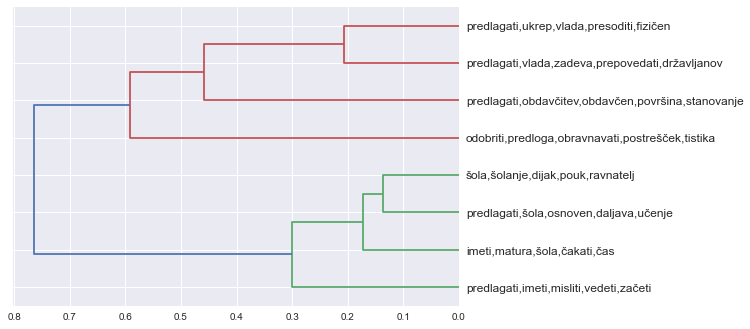

In [8]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

idx = [7, 18, 20, 30, 1, 2, 3, 4]

# dendrogram
plt.style.use('seaborn')
dist_mat = 1 - cosine_similarity(doc_embs[idx, :])
linkage = ward(dist_mat)

# specific words
spec_words = [",".join(doc_desc2[i][:5]) for i in idx]
dendrogram(
    linkage, color_threshold=0.7, 
    labels=spec_words,
    orientation="left"
);